# CS156 - LBA

### Import and processing image

In [1]:
from PIL import Image
import glob
import numpy as np
import re

file_collection = glob.glob('tower_bridge_photo_nov_21/*.jpg')
file_collection = sorted(file_collection)

image_set = []
time_set = []
for filename in file_collection:
    img = Image.open(filename)
    img = img.resize((504, 378))   # reshape to smaller image, maintaining original shape
    img_data = list(img.getdata())
    img.close()
    img_data = np.array(list(map(list, img_data)))
    img_data = img_data.flatten()
    image_set.append(img_data)
    time_data = re.search('tower_bridge_photo_nov_21/(.*).jpg', filename).group(1)
    time_data = time_data.replace("_", ":")   # extracting and formatting time information from filename
    time_set.append(time_data)
    
image_set = np.array(image_set)
image_set = image_set / 255.0   # normalize data

### Plot the original image data

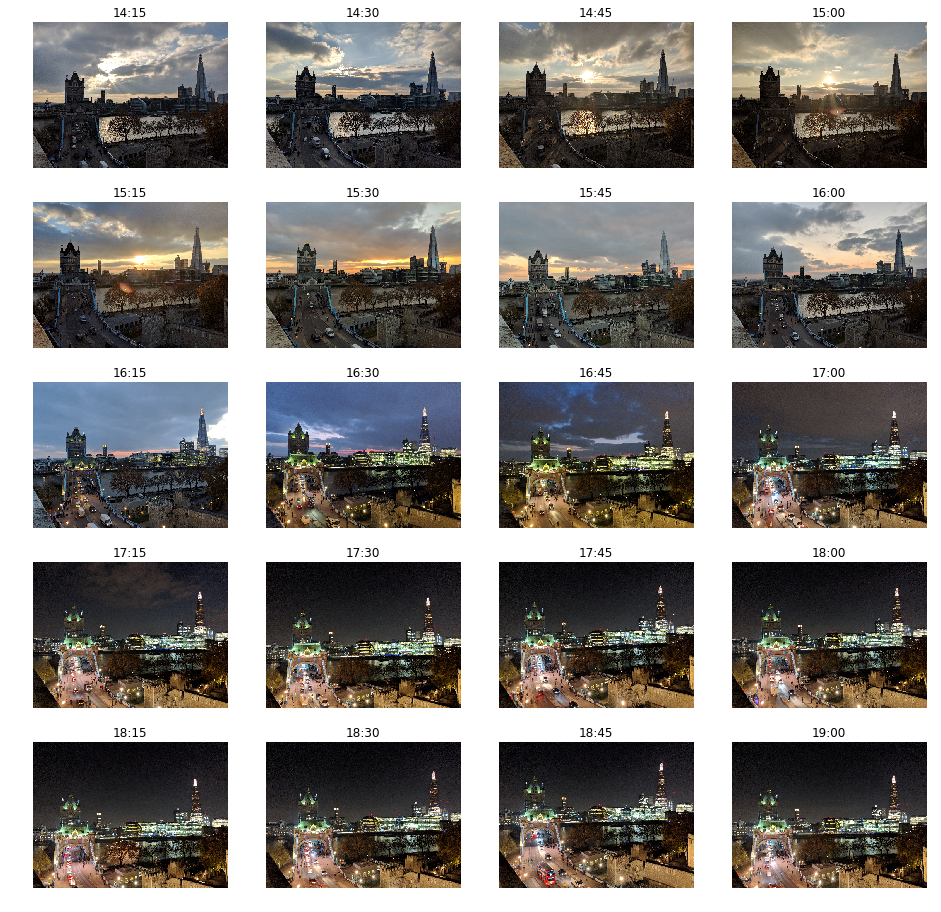

In [59]:
import matplotlib.pyplot as plt

def print_group_image(image, title, row, column, normalize=False, plot_size=[16,16]):
    plt.rcParams['figure.figsize'] = plot_size
    
    if normalize:
        i_max = image.max()
        i_min = image.min()
        image = (image - i_min) / (i_max - i_min)

    count = 1
    for key, image in enumerate(image):
        plot_image = image.reshape(378, 504, 3)
        plt.subplot(row, column, count)
        plt.title(title[key])
        plt.axis('off')
        plt.imshow(plot_image)
        count += 1

    plt.show()


print_group_image(image_set, time_set, 5, 4)

### Use PCA to reduce image into 2d data

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_image_set = pca.fit_transform(image_set)
print ("PCA explained ratio in 1st dimension is {:2f}\nPCA explained ratio in 2nd dimension is {:2f}"
       .format(*pca.explained_variance_ratio_))

PCA explained ratio in 1st dimension is 0.610540
PCA explained ratio in 2nd dimension is 0.049144


### Plot the position of data

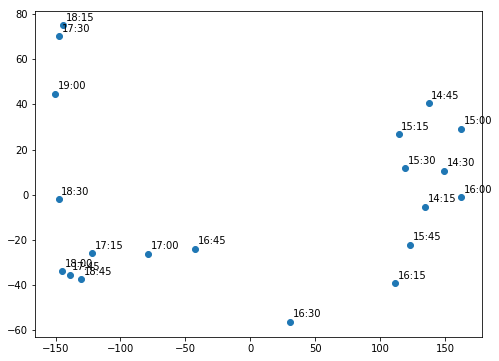

In [38]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]

D_1 = pca_image_set[:,0]
D_2 = pca_image_set[:,1]

plt.scatter(x = D_1, y = D_2)

for key, label in enumerate(time_set):
    plt.text(D_1[key]+2, D_2[key]+2, label)
plt.show()

We can see clearly there are two clusters of data. With images taken in the afternoon at the right (14:00-16:00) and images taken in the evening at the left (17:00-19:00). Images taken during the sunset capture the transition between the two clusters (16:00-17:00). This shows a strong indication that the x-axis (1st dimension produced by the PCA) representing the lighting condition of the image, which in this case the difference between daylight image and night image. The y-axis (2nd dimension produced by the PCA) fluctuate among data across all time, which I would suspect represent the difference in position the photo is taken (as the image was not collected from a camera on a set tripod, so there is a significant fluctuation of position).

### Reconstruction of the original image data

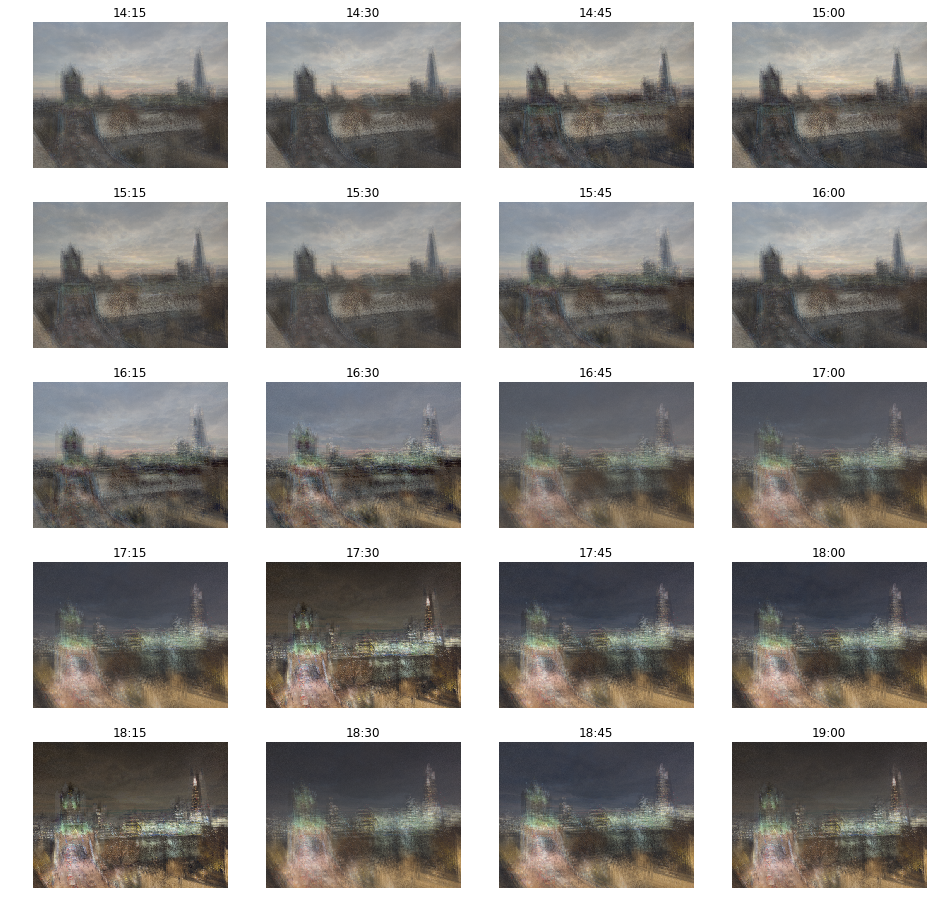

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 16]

reconstruct_image_set = pca.inverse_transform(pca_image_set)

print_group_image(reconstruct_image_set, time_set, 5, 4, True)

### Generate image projection for new points

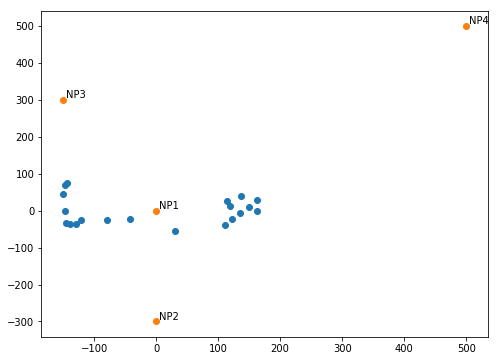

In [70]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

new_point_set = np.array([[0,0], [0, -300], [-150, 300], [500, 500]])

D_1 = pca_image_set[:,0]
D_2 = pca_image_set[:,1]

plt.scatter(x = D_1, y = D_2)

N_1 = new_point_set[:,0]
N_2 = new_point_set[:,1]

plt.scatter(x = N_1, y = N_2)

for i in range(4):
    plt.text(N_1[i]+5, N_2[i]+5, "NP{:d}".format(i+1))
plt.show()

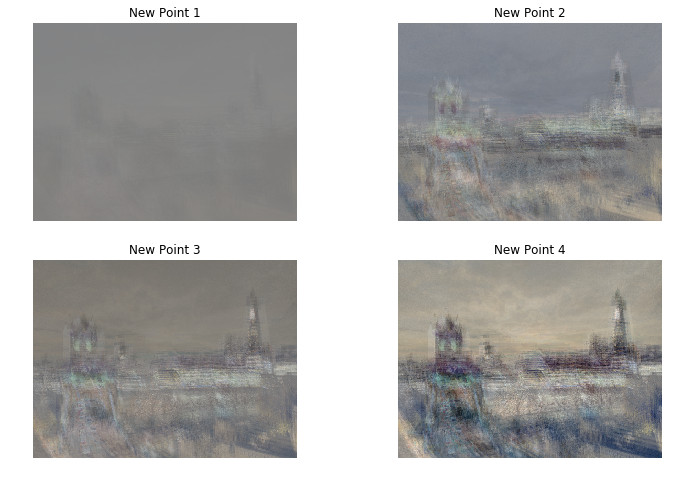

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

reconstruct_new_point_set = pca.inverse_transform(new_point_set)
new_point_label = ["New Point {:d}".format(i) for i in range(1,5)]

print_group_image(reconstruct_new_point_set, new_point_label, 2, 2, True, [12, 8])

### Extension-1: what each dimension represents

In general, when applying PCA to image data, the 1st and strongest dimension finds the difference in brightness as brightness tend to be the things various the most in image data. The 2nd dimension finds the general shape or the average shape. To conform to these general case, I will reproduce the images by setting each of the two dimensions to 0 (the mean of all images) and reproduce the image to show how it differs.

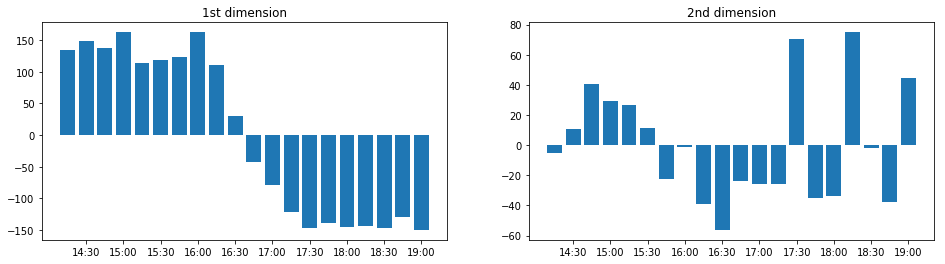

In [54]:
plt.rcParams['figure.figsize'] = [16, 4]

count = 1
text = ["1st", "2nd"]
for i in range(0, 2):
    plt.subplot(1, 2, count)
    plt.bar(np.arange(20), pca_image_set[:,i].flatten())
    plt.xticks(np.arange(1, 20, 2), time_set[1::2])
    plt.title("{:s} dimension".format(text[i]))
    count += 1

plt.show()

This bar chart confirms the finding above. The first dimension changes as time progress and lighting condition changes from daylight to night. Where the second dimension has no obvious pattern in them, showing noize in the image data.

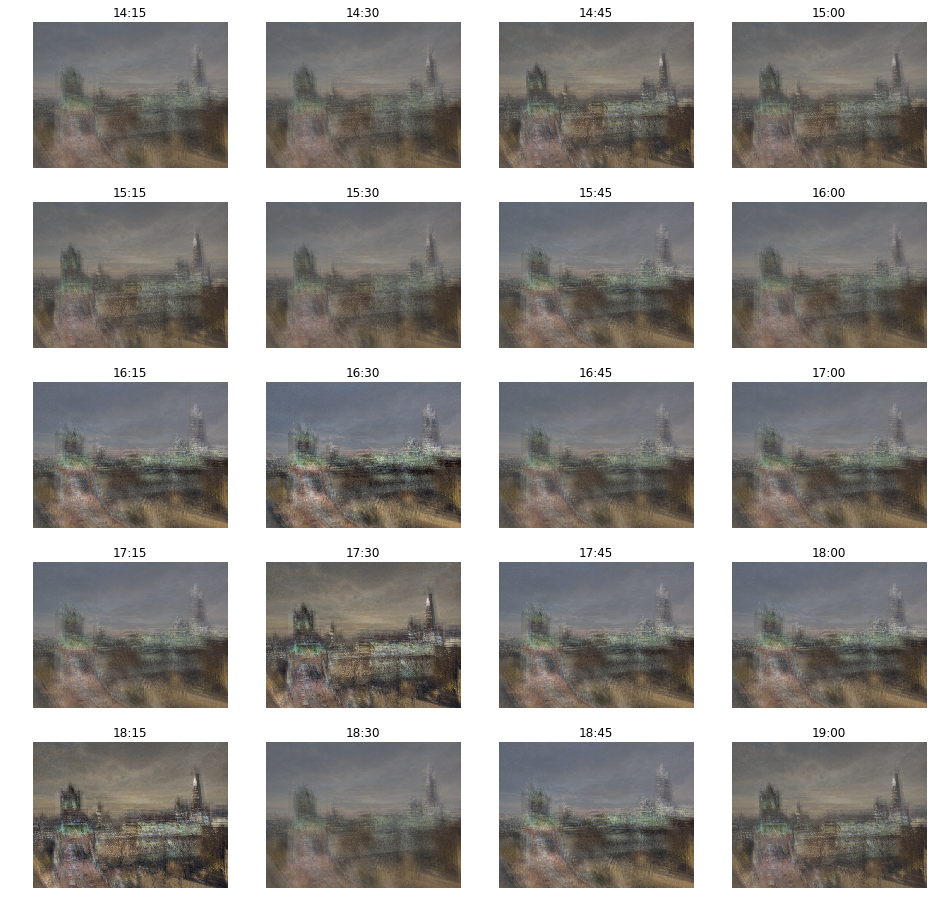

In [57]:
import copy

pca_image_set_ignore_1st = copy.deepcopy(pca_image_set)
pca_image_set_ignore_1st[:,0] = np.zeros(shape=(20))   # ignore information from 1st dimension by setting to 0
reconstruct_image_set_ignore_1st = pca.inverse_transform(pca_image_set_ignore_1st)

print_group_image(reconstruct_image_set_ignore_1st, time_set, 5, 4, True)

As we expected, by setting the first dimension to the mean value 0, we are overving all of the reproduced images at a similar lighting condition.

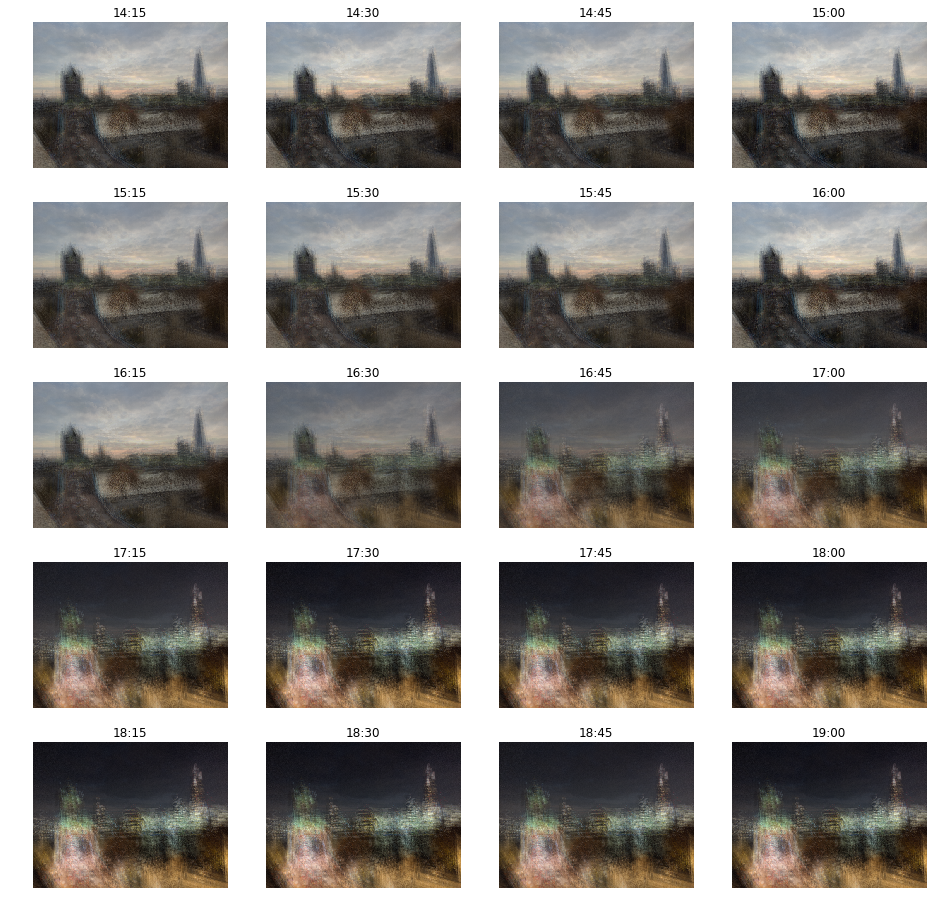

In [58]:
import copy

pca_image_set_ignore_1st = copy.deepcopy(pca_image_set)
pca_image_set_ignore_1st[:,1] = np.zeros(shape=(20))   # ignore information from 2nd dimension by setting to 0
reconstruct_image_set_ignore_1st = pca.inverse_transform(pca_image_set_ignore_1st)

print_group_image(reconstruct_image_set_ignore_1st, time_set, 5, 4, True)

By setting the second dimension the mean value 0, the reproduced images are becoming more similar in there shape and a lot more blurry (note the difference is not nearly as pronounced as the first dimension, which is expected as the explained ratio of the second dimension is less then 1/10 of the first dimension).

### Extension-2: transform lighting condition of image using PCA

As the first dimension of PCA projection capture the brightness and lighting condition of the image, we can use this information to attempt changing a daytime image to nighttime or vice versa. This is not likely to produce convincing result as generally the first dimension of PCA only factor the general brightness and some tone of the image. However, it should produce some interesting image.

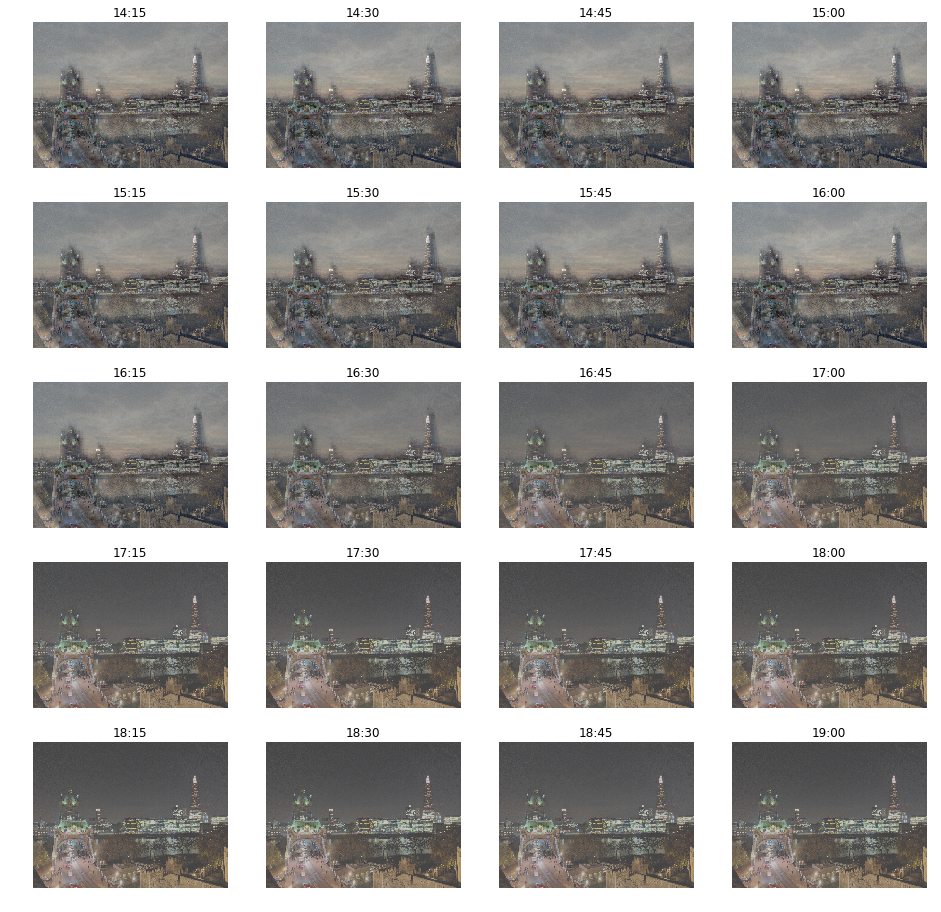

In [102]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 16]

# construct at PCA projection that captures 99.99% variance of the data
# this will make the reproduced image much sharper, as most of the information is retained
pca_99 = PCA(.9999)
pca_99_image_set = pca_99.fit_transform(image_set)

# 
brightness_dimension = pca_99_image_set[:,0]
evening_frame_set = np.repeat(pca_95_image_set[19], 20, axis=0) \
                    .reshape(pca_95_image_set.shape[1], 20).T   # make 20 copy of the 19:00 data
evening_frame_set[:,0] = brightness_dimension   # set the 1st (brightness) dimension to each time frame respectively


reconstruct_95_image_set = pca_95.inverse_transform(evening_frame_set)

print_group_image(reconstruct_95_image_set, time_set, 5, 4, True)

As we observed, this process did manage to alter the general lighting condition of the image, bringing the night image of 7 pm London to a kind of sunny afternoon. However, this only gives a very general change in the lighting condition. Even major details like the evening lighting of the city remain unchanged in the constructed images. Importantly is a fun/ artistic reproduction overall.